In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 线性回归的从零开始实现 定义和读取数据

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)    # 此处+一个随机的噪音[0,0.01]
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.7829, 0.6070]) 
label: tensor([3.6919])


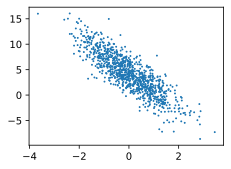

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)   # 样本随机打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 返回下X,Y

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2247, -0.3334],
        [-0.7418, -0.1360],
        [ 1.9573,  0.9552],
        [-0.0801,  0.9419],
        [ 0.7865, -0.0546],
        [-0.2634,  0.2516],
        [-1.0562, -0.2681],
        [ 0.8904, -0.6520],
        [-0.3388, -0.5823],
        [-0.7424,  0.8618]]) 
 tensor([[ 5.7783],
        [ 3.1792],
        [ 4.8664],
        [ 0.8245],
        [ 5.9489],
        [ 2.8151],
        [ 3.0065],
        [ 8.1886],
        [ 5.5037],
        [-0.1947]])


### 初始化模型参数和定义模型

In [58]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  #正态分布  requires_grad=True：需要计算梯度
b = torch.zeros(1, requires_grad=True)

In [59]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [60]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

In [61]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程

In [65]:
lr = 0.001
num_epochs = 20
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.990632
epoch 2, loss 0.809652
epoch 3, loss 0.661739
epoch 4, loss 0.540856
epoch 5, loss 0.442060
epoch 6, loss 0.361314
epoch 7, loss 0.295319
epoch 8, loss 0.241384
epoch 9, loss 0.197302
epoch 10, loss 0.161274
epoch 11, loss 0.131827
epoch 12, loss 0.107758
epoch 13, loss 0.088085
epoch 14, loss 0.072007
epoch 15, loss 0.058865
epoch 16, loss 0.048124
epoch 17, loss 0.039344
epoch 18, loss 0.032169
epoch 19, loss 0.026303
epoch 20, loss 0.021509


In [66]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0674, -0.1285], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.1471], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现

In [68]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [69]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [70]:
next(iter(data_iter))

[tensor([[-1.0920, -0.3102],
         [ 0.0406,  0.6627],
         [-1.2397,  0.9738],
         [-1.5456, -0.2492],
         [-1.0455,  0.2139],
         [ 1.5297,  0.2794],
         [-0.7229,  0.0089],
         [-0.0269,  0.1373],
         [ 0.4395, -0.8787],
         [-0.0438,  1.1285]]),
 tensor([[ 3.0655],
         [ 2.0396],
         [-1.5839],
         [ 1.9601],
         [ 1.3664],
         [ 6.3215],
         [ 2.7211],
         [ 3.6765],
         [ 8.0733],
         [ 0.2688]])]

In [71]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [72]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [73]:
loss = nn.MSELoss()

In [74]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [75]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000234
epoch 2, loss 0.000096
epoch 3, loss 0.000096


In [76]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([5.4336e-04, 9.2745e-05])
b的估计误差： tensor([0.0002])
